# How to tf.function to speed up Python code in Tensorflow


_tf.function is a decorator function provided by Tensorflow 2.0 that converts regular python code to a callable Tensorflow graph function, which is usually more performant and python independent. It is used to create portable Tensorflow models._

Table of Contents:
1. Introduction
2. Why do we need graphs?
3. How can you create graphs in TF2.0
4. Flow control - changes made by Autograph
5. Side effects of using `tf.function` you must be aware of
6. Polymorphic functions
7 Limitations in speed up from using `tf.function`
8. References


## 1. Introduction

Tensorflow released the second version of the library in September 2019. This version, popularly called Tensorflow2.0 marked significant changes from the previous Tensorflow1.x version.

**TF2.0 allows user to build dynamic computation graphs through a feature called eager execution**. Even though eager execution is widely preferred for easier debugging and no need for `tf.session` calls, there are some cases when as a user you might still want to **lazy execution** (static computation graphs) like when you want to improve the code run time performance.

This is why TF2.0 has the `tf.function` API, to give any user the option to convert a regular (eager) python code to a lazy code which is actually speed optimized.

This tutorial will bring you up to speed with:
1. All that the `tf.function` has to offer
2. Why many developers still use graphs for deployment and 
3. How tf.function can actually speed up your code. 

Let's begin

## 2. Why do we need graphs?

As you already read above, eager execution is a better choice for easy debugging and more intuitive programming using Python. It is the same as writing regular python code, where you can run your code line by line in console, or as a script and debug your code using `pdb`.  

However, running TensorFlow code step-by-step (as in eager execution) in Python prevents a host of accelerations otherwise available in the lazy mode. If you can extract tensor computations from Python, you can make them into a graph.

You may ask, what are graphs in the first place?

*Graphs are a type of data structures that contains tensors and the computations performed. Graphs store the flow of information and operations between tensors through tf.Operation objects and tf.Tensor tensors.*

But, why use Graphs?

1. The primary reason is, __graphs allow 
your neural network model to be used in environments that dont have a Python interpreter__. For example, graphs can be deployed in mobile applications or servers. This is not suitable for eagerly executed code.

2. The second reason is that __graphs can speed up computation time__. They eliminate the need for repetitive initialisation of variables and computation on these variables. 

They store this information once, when the graph is defined and then all new tensors and variables make use of this existing graph.

This might not make sense right now, but you will see this speedup in action in upcoming section below.

## 3. How can you create graphs in TF2.0?

The `tf.function` API is used in TF2.0 to create graphs for eagerly executed code.

There are two ways you can use this.

1. __As a decorator__: Using `@tf.function` decorator before your code will create a graph for that piece of code.

Let's look at an example.

In [17]:
# Decorate using @tf.function
import tensorflow as tf
import time
from datetime import datetime

@tf.function
def function(x):
  a = tf.constant([[2.0], [3.0]])
  b = tf.constant(4.0)
  return a+b

You can see that we have used the `@tf.function` decorator. This means that a graph for this function has been created. Let's test it by calling the function with some input and then visualising it using Tensorboard.

In [ ]:
# Plot a graph for function() using Tensorboard
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = 'logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)

tf.summary.trace_on(graph=True, profiler=True)
# Call only one tf.function when tracing.
z = function(2)
with writer.as_default():
  tf.summary.trace_export(
      name="function_trace",
      step=0,
      profiler_outdir=logdir)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/func

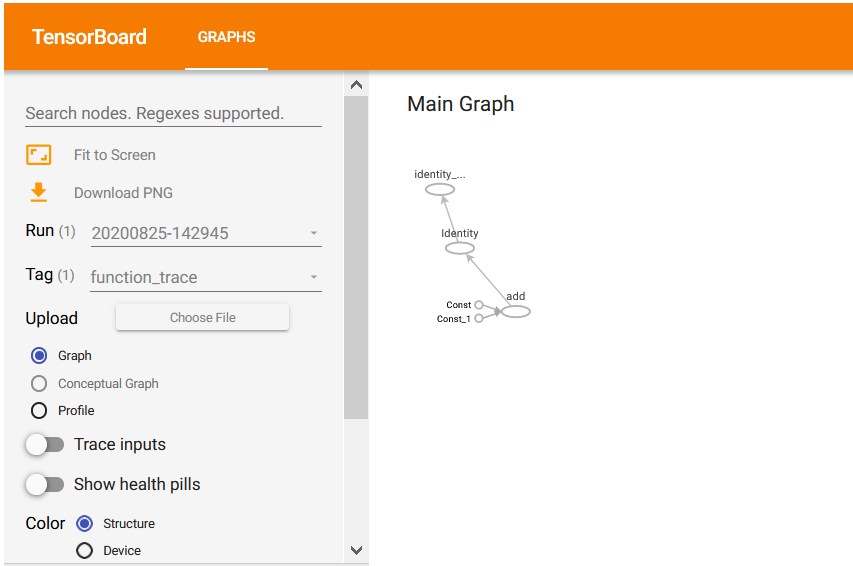

Here you can see the graph for our created function `function()`.
Let's see what is the other method of creating graphs through `tf.function`.

2. __As a callable function__ : In this method you can simply `tf.function`-ise an existing function to create a graph for that function.

Practically, this is the same as what applying a decorator to a function does. This example simply makes it explicit.

In [ ]:
# Define a Python function
def callable_func(a, b):
  return tf.matmul(a, b)

# Create a `Function` object that contains a graph
function_that_uses_graph = tf.function(callable_func)

# Make some tensors
a1 = tf.constant([[1.0, 2.0]])
b1 = tf.constant([[2.0], [3.0]])
  
# It works!
function_that_uses_graph(a1, b1).numpy()



array([[8.]], dtype=float32)

The question that arises is, how much does `tf.function` speed up operations in Tensorflow?

Let's look at this speed up by observing the code-run time for a code as it is and then with `tf.function` decorator.

In [20]:
class SequentialModel(tf.keras.Model):
  def __init__(self, **kwargs):
    super(SequentialModel, self).__init__(**kwargs)
    self.flatten = tf.keras.layers.Flatten(input_shape=(28, 28))
    self.dense_1 = tf.keras.layers.Dense(128, activation="relu")
    self.dropout = tf.keras.layers.Dropout(0.2)
    self.dense_2 = tf.keras.layers.Dense(10)

  def call(self, x):
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.dropout(x)
    x = self.dense_2(x)
    return x

input_data = tf.random.uniform([60, 28, 28])

eager_model = SequentialModel()
graph_model = tf.function(eager_model)

print("Eager time:", timeit.timeit(lambda: eager_model(input_data), number=10000))
print("Graph time:", timeit.timeit(lambda: graph_model(input_data), number=10000))


Eager time: 7.824499414999991
Graph time: 5.808633186999941


In the above code snippet, we have implemented a classification Sequential model with a lot of small layers. You will be able to see the effect of `tf.function` on code-time speed up only for functions that have a lot of complex operations.

For small functions called a few times on a single machine, there wont be much effect.

This is why for the above model, you can see a considerable difference in execution time for eager mode and graph mode.

## 4. Flow control - changes made by Autograph

When you use `tf.function`, flow control and loops written in Python are converted to TensorFlow compatibe code via `tf.autograph` by default. 



In [ ]:
# Define a new function and `tf.function`-ise it
def my_function(x):
  if tf.reduce_sum(x) <= 1:
    return x * x
  else:
    return x-1

a_function = tf.function(my_function)

print("First branch, with graph:", a_function(tf.constant(1.0)).numpy())
print("Second branch, with graph:", a_function(tf.constant([5.0, 5.0])).numpy())

First branch, with graph: 1.0
Second branch, with graph: [4. 4.]


You can directly call the Autograph conversion to see how Python is converted into TensorFlow compatible code. This is, mostly, unreadable, but you can see the transformation.

In [ ]:
# See how autograph converts python code to make it TF-compatible
print(tf.autograph.to_code(my_function))

def tf__my_function(x):
    with ag__.FunctionScope('my_function', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (do_return, retval_)

        def set_state(vars_):
            nonlocal do_return, retval_
            (do_return, retval_) = vars_

        def if_body():
            nonlocal do_return, retval_
            try:
                do_return = True
                retval_ = (ag__.ld(x) * ag__.ld(x))
            except:
                do_return = False
                raise

        def else_body():
            nonlocal do_return, retval_
            try:
                do_return = True
                retval_ = (ag__.ld(x) - 1)
            except:
                do_return = False
                raise
        ag__.if_stmt((ag__.converted_call(ag__.ld(tf).reduce_sum, (ag

Autograph performs this transformation for all Python control loops like for-loop, while-loop and if-else loop.

## 5. Side-effects of using tf.function you must be aware of


__When you call a function that you've decorated with tf.function, functions like printing, appending to lists, and mutating globals gets implemented only for first time. From second time onwards they get ignored.__ 

#### Side Effect 1: print() works only once

Afterwards, the traced `tf.Graph` is reexecuted, without executing the Python code.

Let's look at a code example to gain a better understanding.

In [ ]:
# See in action how the print statement executes only once sue to Python side effect!
@tf.function
def f(x):
  print("Traced with", x)
  tf.print("Executed with", x)

f(1)
f(1)


Traced with 1
Executed with 1
Executed with 1


Here, the `print()` statement was executed only for the first time f(1) was called. For the second time, as a graph had already been traced, this Python code wasnt reexecuted and thus the statement 'Traced with 1' is not seen.

#### Side Effect 2: Iterator works only once

Another example of a Python side effect is with generators and iterators within a `tf.function` code block.

In case of a iterator, the iterator state advances only once, during tracing. Let's see an example.

In [ ]:
# Iterator side effect in action; the value of iterator advances only once during tracing
var = tf.Variable(0)

@tf.function
def side_effect(iterator):
  var.assign_add(next(iterator))
  tf.print("Value of variable:", var)

iterator = iter([0, 1, 2, 3])
side_effect(iterator)

# This reuses the first value from the iterator, rather than consuming the next value.
side_effect(iterator)
side_effect(iterator)


Value of variable: 0
Value of variable: 0
Value of variable: 0


The results you should get, if not using `tf.function` decorator is something like this:

In [ ]:
# Results of using iterator without tf.function
var = tf.Variable(0)

def side_effect(iterator):
  var.assign_add(next(iterator))
  tf.print("Value of variable:", var)

iterator = iter([0, 1, 2, 3])
side_effect(iterator)
side_effect(iterator)
side_effect(iterator)


Value of variable: 0
Value of variable: 1
Value of variable: 3


The general rule of thumb is to only use Python side effects to debug your traces. Otherwise, TensorFlow functions like `tf.Variable.assign` and `tf.print` are the best way to ensure your code will be executed by Tensorflow for every call.

## Polymorphic Functions

`tf.function` is polymorphic. 

That means, a function can work on different datatypes and for each datatype it will create a new graph, or in other words, retrace an existing graph.

TF will store distinct graphs for each datatype for a given function. You can access individually by using `concrete_function`.

Let's understand this through an example.

In [ ]:
# Define a function using tf.function decorator
@tf.function
def poly_func(a):
  print("Tracing with", a)
  return a

# Test it's polymorphism
print(poly_func(tf.constant(1)))
print(poly_func(tf.constant(1.1)))
print(poly_func(tf.constant("a")))


Tracing with Tensor("a:0", shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
Tracing with Tensor("a:0", shape=(), dtype=float32)
tf.Tensor(1.1, shape=(), dtype=float32)
Tracing with Tensor("a:0", shape=(), dtype=string)
tf.Tensor(b'a', shape=(), dtype=string)


Here the function `poly_func` has been traced thrice, once for integer datatype, once for float datatype and once for string datatype.

If we use the same function for any of these datatypes again, no retracing will occur the existing graph will be used.

In [ ]:
# This doesn't print 'Tracing with ...'
print(poly_func(tf.constant(3.6)))


tf.Tensor(3.6, shape=(), dtype=float32)


You can use `pretty_printed_concrete_signatures()` to see all of the available polymorphic forms:

In [ ]:
# Print Function signatures
print(poly_func.pretty_printed_concrete_signatures())

poly_func(a)
  Args:
    a: float32 Tensor, shape=()
  Returns:
    float32 Tensor, shape=()

poly_func(a)
  Args:
    a: int32 Tensor, shape=()
  Returns:
    int32 Tensor, shape=()

poly_func(a)
  Args:
    a: string Tensor, shape=()
  Returns:
    string Tensor, shape=()


Further, you can obtain a concrete function for the graph of a particular datatype by using `get_concrete_function`. This function obtained will only work with the specified datatype.

Below we have obtained the concrete function for integer datatype.

In [ ]:
# Get the concrete func
print("Obtaining concrete trace")
polyfunc_int = poly_func.get_concrete_function(tf.constant(3))

print("Executing traced function")
print(polyfunc_int(tf.constant(5)))
print(polyfunc_int(a=tf.constant(6)))

Obtaining concrete trace
Executing traced function
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)


If you call `polyfunc_int` for any other dtype apart from integer, you will get an error. Below, let's pass a float when an integer is expected:

In [ ]:
# A concrete fucntion throws errors for other data types
print(polyfunc_int(tf.constant(7.4)))

InvalidArgumentError: ignored

In practice, you will rarely need to use concrete functions.

## Limitations in speed-up from using `tf.function`

Just wrapping a tensor-using function in tf.function does not automatically speed up your code. 

For small functions called a few times on a single machine, the overhead of calling a graph or graph fragment may dominate runtime. Also, if most of the computation was already happening on an accelerator, such as stacks of GPU-heavy convolutions, the graph speedup won't be large.

For complicated computations, graphs can provide a signficiant speedup. This is because graphs reduce the Python-to-device communication, and perform some speedups.

## References

1. Tensorflow [documentation](https://www.tensorflow.org/guide/function#obtaining_concrete_functions)
2. Getting started with Tensorflow 2.0 - Pluralsight (Janani Ravi)